## Reinforcement Learning Tarea 1 - K Armed Bandits

### Objetivos:
Demostrar entendimiento sobre K-Armed Bandits, implementar varios algoritmos vistos en el curso teórico y comparar su performance en un mismo problema (ambiente).

### A entregar:
- Implementación de agente arbitrario.
- Implementación de agente epsilon-greedy.
- Implementación de agente epsilon-greedy optimista.
- Implementación de agente upper confidence bound.
- Grafique la evolución de las recompensas (reward) a lo largo del tiempo para cada algoritmo, promediado sobre 2000 ejecuciones.
- Escriba un reporte sobre sus implementaciones comparando los distintos agentes implementados.

### Instalación y carga de ambiente

`git clone https://github.com/JKCooper2/gym-bandits.git`

`cd gym-bandits`

`pip install .`

In [1]:
# Para usarlo desde Google Colab
!git clone https://github.com/JKCooper2/gym-bandits.git
!cd gym-bandits
!pip install gym-bandits/

Cloning into 'gym-bandits'...
remote: Enumerating objects: 73, done.
remote: Total 73 (delta 0), reused 0 (delta 0), pack-reused 73
Unpacking objects: 100% (73/73), 14.65 KiB | 833.00 KiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./gym-bandits
  Preparing metadata (setup.py) ... done
  Created wheel for gym-bandits: filename=gym_bandits-0.0.2-py3-none-any.whl size=5193 sha256=7c9f71e1c5b5da504ef181ef9515e7bb3de7f61b4e423d4bd0cc2898c9ced71d
  Stored in directory: /root/.cache/pip/wheels/5e/c8/e4/747d46ff11ed3fd97fbf7b969a986c0a6f36e5c38eb1373dc3
Successfully built gym-bandits


## Descripción del ambiente a usar

Vamos a usar GymBandits, una libreria diseñada para ser utilizada sobre OpenAi Gym (https://gym.openai.com/) pero orientada a Armed Bandits. 

Recordando el teórico, sabemos que un K Armed Bandit representa una maquina tragamonedas con multiples brazos (K) y donde nuestra recompensa depende de cual brazo tiremos.

En este caso particular, `BanditTenArmedGaussian` es el ambiente a utilizar (página 30 del libro de Sutton y Barto), cuenta con 10 brazos (K=10) y por cada interaccion con el ambiente (`step`) nustra recompensa (reward) depende de que brazo elegimos entre los 10 posibles. En este ambiente, todos los brazos tienen una recompensa (que puede ser negativa en algunos casos) y nuestro objetivo es diseñar agentes que maximicen la suma total de recompensas a lo largo de 1000 interacciones con el ambiente (`1000 steps`).

## Definicion del ambiente e imports necesarios

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
run '/content/drive/Othercomputers/Mi portátil/Master en Big Data - Universidad ORT/2do Cuatrimestre/Agentes Inteligentes/Tarea 1 - K Armed Bandits/Agent.py' 

In [2]:
import gym
import random
import gym_bandits
import numpy as np
import matplotlib.pyplot as plt

def get_env():
    return gym.make("BanditTenArmedGaussian-v0")    

In [3]:
sample_env = get_env()
sample_env.action_space

Discrete(10)

In [4]:
sample_env.reset()

c:\Users\maria\.conda\envs\DS\lib\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
c:\Users\maria\.conda\envs\DS\lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
c:\Users\maria\.conda\envs\DS\lib\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'int'>`
  logger.warn(


0

In [5]:
sample_env.step(1)

c:\Users\maria\.conda\envs\DS\lib\site-packages\gym\utils\passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


(0, -0.9918012651013901, True, {})

In [6]:
number_steps = 1000

In [7]:
from Agent import Agent
sample_env.reset() 

0

### Implementación de agente arbitrario

In [8]:
class RandomAgent(Agent):
    def __init__(self, name):
        super().__init__(name)        

    def reset_internal_state(self):
        pass

    def select_action(self, game_state):
        return self.environment.action_space.sample()
   
    def update_internal_state(self, observation, action, reward):
        pass
    
    def get_extra_info(self):
        return None

# Example run
sample_env.reset() 
random_agent = RandomAgent("RandomAgent")



In [9]:
sample_env.reset()
logs, info = random_agent.play(n_steps = 1000, environment = sample_env)

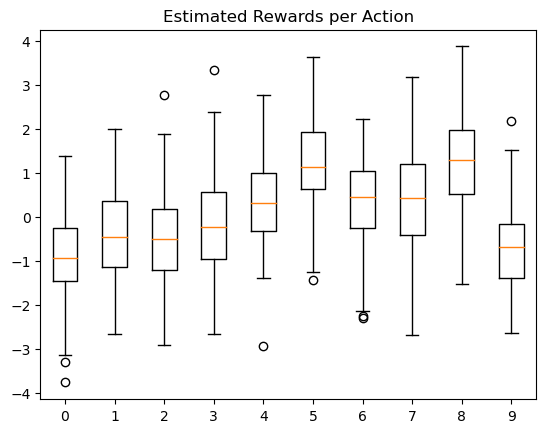

In [10]:
data = list(map(lambda x: np.array(x), logs['actions_rewards'].values()))
labels = list(logs['actions_rewards'].keys())
fig1, ax1 = plt.subplots()
ax1.set_title('Estimated Rewards per Action')
a = ax1.boxplot(data, labels = labels)

In [11]:
print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

Accumulated reward: 99.71
Mean reward: 0.10


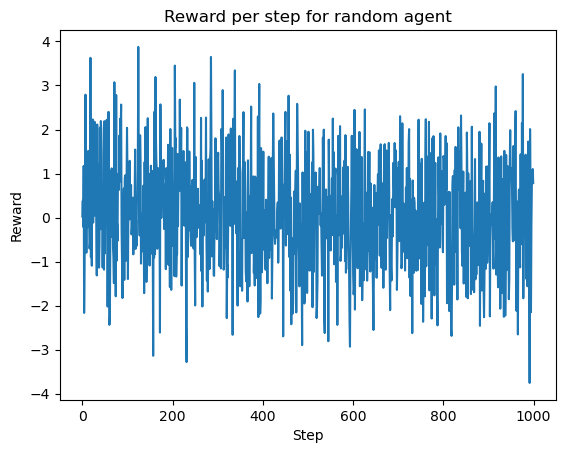

In [12]:
# Example plot
plt.plot(range(number_steps), logs['rewards'])
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Reward per step for random agent")
plt.show()

### Implementación de agente epsilon-greedy

In [13]:
class EpsilonGreedyAgent(Agent):
    def __init__(self, name, epsilon):
        super().__init__(name)
        self.epsilon = epsilon        

    def reset_internal_state(self):
        self.q = np.zeros(self.environment.action_space.n)
        self.n = np.zeros(self.environment.action_space.n)


    def select_action(self, game_state):
        rnd = random.random()
        if rnd < self.epsilon:
          action = self.environment.action_space.sample()
        else:
          action = np.argmax(self.q)
        return action

   
    def update_internal_state(self, observation, action, reward):
        self.n[action] = self.n[action] + 1
        self.q[action] = self.q[action] + (1/self.n[action])*(reward - self.q[action])
    
    def get_extra_info(self):
        return {"q_a":self.q,"n_a":self.n}

# Example run
epsilon_greedy_agent = EpsilonGreedyAgent("EpsilonGreedyAgent", 0.3)

logs, info = epsilon_greedy_agent.play(n_steps = 1000, environment =sample_env)
print(info['n_a'])
print(info['q_a'])
print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

[ 41.  35.  39.  27.  96. 520.  30.  32. 152.  28.]
[-0.7922872  -0.42757301 -0.42494624  0.07349239  0.48971116  1.3170751
  0.27722703  0.63466299  1.11574758 -0.51914953]
Accumulated reward: 853.54
Mean reward: 0.85


In [14]:
#np.fu(3)*2

AttributeError: module 'numpy' has no attribute 'fu'

### Implementación de agente epsilon-greedy optimista

In [15]:
class OptimisticEpsilonGreedyAgent(Agent):
    def __init__(self, name, epsilon, q_1):
        super().__init__(name) 
        self.epsilon = epsilon
        self.q_1 = q_1      

    def reset_internal_state(self):
        #self.q = np.ones(self.environment.action_space.n)*self.q_1
        self.q = np.full(self.environment.action_space.n,float(self.q_1))
        self.n = np.zeros(self.environment.action_space.n)

    def select_action(self, game_state):
        rnd = random.random()
        #if self.n == 0:
         # action = self.q_1
        #else: 
        if rnd < self.epsilon:
          action = self.environment.action_space.sample()
        else:
          action = np.argmax(self.q)
        return action
   
    def update_internal_state(self, observation, action, reward):
        self.n[action] = self.n[action] + 1
        self.q[action] = self.q[action] + (1/self.n[action])*(reward - self.q[action])
    
    def get_extra_info(self):
        return {"q_a":self.q,"n_a":self.n}

# Example run
optimistic_epsilon_greedy_agent = OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent", 0.3, q_1 = 10)

logs, info = optimistic_epsilon_greedy_agent.play(n_steps = 1000, environment =sample_env)
print(info['n_a'])
print(info['q_a'])
print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

[ 34.  23.  30.  39.  20. 723.  34.  34.  31.  32.]
[-0.85249024 -0.70561127 -0.35986483 -0.14502568  0.5535994   1.32568057
  0.25771626  0.45735892  0.98249904 -0.66849234]
Accumulated reward: 941.25
Mean reward: 0.94


### Implementación de agente upper confidence bound

In [19]:
class UCBAgent(Agent):
    def __init__(self, name, C):
        super().__init__(name)
        self.C = C        

    def reset_internal_state(self):
      self.q = np.zeros(self.environment.action_space.n)
      self.n = np.ones(self.environment.action_space.n)

    def select_action(self, game_state):
        t = np.sum(self.n)
        action = np.argmax(self.q+self.C*np.sqrt(np.log(t)/self.n))
        return action
   
    def update_internal_state(self, observation, action, reward):
        self.n[action] = self.n[action] + 1
        self.q[action] = self.q[action] + (1/self.n[action])*(reward - self.q[action]) 
    
    def get_extra_info(self):
        return {"q_a":self.q,"n_a":self.n}

# Example run
sample_env.reset()
UCB_agent = UCBAgent("UCBAgent", 1)

logs, info = UCB_agent.play(n_steps = 1000, environment =sample_env)
print(info['n_a'])
print(info['q_a'])
print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

[  3.   6.   2.  13.  10.   5.  13. 142. 812.   4.]
[-0.7560926  -0.1348255  -0.74550096  0.26142814  0.14306581 -0.25461904
  0.24949615  0.7396016   1.148871   -0.62246438]
Accumulated reward: 1037.65
Mean reward: 1.04


### Reporte

In [ ]:
def calculate_mean_rewards_and_selected_optimal_action_by_step(n_runs, n_steps, agent_constructor, param):
    many_rewards = []
    many_selected_best_action = []
    for i in range(n_runs):
        env = get_env()
        agent = agent_constructor(param)
        logs, info = agent.play(n_steps, env)
        many_rewards.append(logs['rewards'])
        many_selected_best_action.append(logs['selected_best_action'])
    mean_rewards = np.mean(many_rewards, axis = 0)
    mean_selected_best_action = np.mean(many_selected_best_action, axis = 0)    
    return {"mean_rewards": mean_rewards, "mean_selected_best_action":mean_selected_best_action}

In [ ]:
from functools import partial 

parameters_eps_greedy = [0, 0.1, 0.01]

#Para epsilon greedy optimista con tasa de actualización no fija con que Q0 esté sobre la media basta (default 10 = OK)
parameters_eps_greedy_opt = [0, 0.1, 0.01]


parameters_ucb = [0.25, 0.5, 1, 2, 4]

n_runs = 2000
n_steps = 1000

eps_greedy_results = list(map(lambda x: (x,calculate_mean_rewards_and_selected_optimal_action_by_step(n_runs, n_steps, partial(EpsilonGreedyAgent, "EpsilonGreedyAgent"),x)), parameters_eps_greedy))

eps_greedy_opt_results = list(map(lambda x: (x,calculate_mean_rewards_and_selected_optimal_action_by_step(n_runs, n_steps, partial(OptimisticEpsilonGreedyAgent, "EpsilonGreedyAgent", q_1 = 10)  ,x)), parameters_eps_greedy_opt))

ucb_results = list(map(lambda x: (x,calculate_mean_rewards_and_selected_optimal_action_by_step(n_runs, n_steps, partial(UCBAgent, "UCBAgent"),x)), parameters_ucb))

In [ ]:
def plot_results(results, param_name, metric, plot_title, x_label, y_label, n_steps):
    plt.figure(figsize=(10,5))
    for param, means in results:
        plt.plot(range(n_steps), means[metric], label=param_name+' = '+str(param))        
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.legend()
    plt.show()

#### Epsilon Greedy:

In [ ]:
plot_results(eps_greedy_results, "epsilon","mean_rewards","Mean Reward per step for epsilon-greedy agent","Step","Reward", n_steps)
plot_results(eps_greedy_results, "epsilon","mean_selected_best_action","% of times best action was selected step for epsilon-greedy agent","Step","% Optimal action", n_steps)

#### Comentarios:


#### Epsilon Greedy Optimista:

In [ ]:
plot_results(eps_greedy_opt_results, "epsilon","mean_rewards","Mean Reward per step for optimistic epsilon-greedy agent","Step","Reward", n_steps)
plot_results(eps_greedy_opt_results, "epsilon","mean_selected_best_action","% of times best action was selected step for optimistic epsilon-greedy agent","Step","% Optimal action", n_steps)

#### Comentarios:


#### UCB

In [ ]:
plot_results(ucb_results, "C","mean_rewards","Mean Reward per step for UCB agent","Step","Reward", n_steps)
plot_results(ucb_results, "C","mean_selected_best_action","% of times best action was selected step for UCB agent","Step","% Optimal action", n_steps)

#### Comentarios:

#### A continuación compararemos los que mejor resultado dan en una misma gráfica

In [ ]:
eps_greedy_results_means = list(map(lambda x: (x[0], x[1],np.mean(x[1]['mean_rewards'])), eps_greedy_results))
eps_greedy_opt_results_means = list(map(lambda x: (x[0], x[1],np.mean(x[1]['mean_rewards'])), eps_greedy_opt_results))
ucb_results_means  = list(map(lambda x: (x[0], x[1],np.mean(x[1]['mean_rewards'])), ucb_results))

In [ ]:
best_eps_greedy = max(eps_greedy_results_means,key=lambda item:item[2])
best_eps_greedy_opt = max(eps_greedy_opt_results_means,key=lambda item:item[2])
best_ucb = max(ucb_results_means,key=lambda item:item[2])

In [ ]:
plt.figure(figsize=(10,5))    
plt.plot(range(n_steps), best_eps_greedy[1]['mean_rewards'], label='epsilon greedy, epsilon = '+str(best_eps_greedy[0]))
plt.plot(range(n_steps), best_eps_greedy_opt[1]['mean_rewards'], label='optimistic epsilon greedy, epsilon = '+str(best_eps_greedy_opt[0]))
plt.plot(range(n_steps), best_ucb[1]['mean_rewards'], label='UCB, C = '+str(best_ucb[0]))
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Mean Reward per step for best parameters of agents")
plt.legend()
plt.show()

#### Comentarios:
